In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")

print("Path to dataset files:", path)

path = os.path.join(path,'Garbage_Dataset_Classification' ,'images')

/Users/atharva/miniconda3/envs/pet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/atharva/.cache/kagglehub/datasets/zlatan599/garbage-dataset-classification/versions/5


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DROP_OUT = 0.3
EPOCHS = 10
LEARNING_RATE = 0.0001
NUM_CLASSES = 6
FINE_TUNE_LEARNING_RATE = 0.00001


In [4]:
def load_data():
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,  # Randomly shuffles all images
        seed=123,      # Makes shuffle reproducible
    )   

    total_size = tf.data.experimental.cardinality(full_dataset).numpy()
    train_size = int(0.8 * total_size)  # 80% of batches
    val_size = int(0.1 * total_size)    # 10% of batches
    
    train_dataset = full_dataset.take(train_size)     # First 80% of batches
    remaining = full_dataset.skip(train_size)         # Skip first 80%, get last 20%
    val_dataset = remaining.take(val_size)            # First 10% of remaining (so 10% of total)
    test_dataset = remaining.skip(val_size)           # Skip the validation part, get final 10%
    
    
    return train_dataset, val_dataset, test_dataset



In [5]:
def noramalize(train,val,test):
    normalization_layer = layers.Rescaling(1./255)
    train = train.map(lambda x, y: (normalization_layer(x), y))
    val = val.map(lambda x, y: (normalization_layer(x), y))
    test = test.map(lambda x, y: (normalization_layer(x), y))

    AUTOTUNE = tf.data.AUTOTUNE

    train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val = val.cache().prefetch(buffer_size=AUTOTUNE)
    test = test.cache().prefetch(buffer_size=AUTOTUNE)
    return train,val,test

In [6]:
train_orig,val_orig,test_orig = load_data()
train,val,test = noramalize(train_orig,val_orig,test_orig)
NUM_CLASSES = 6


Found 13901 files belonging to 6 classes.


2025-09-09 01:15:44.645664: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-09-09 01:15:44.645696: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-09 01:15:44.645706: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-09 01:15:44.645722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-09 01:15:44.645731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
def check_class_distribution(dataset, dataset_name, num_batches=None):
    """Check class distribution in a tf.data.Dataset"""
    all_labels = []
    batch_count = 0
    
    # If num_batches is None, check all batches (might be slow)
    dataset_to_check = dataset.take(num_batches) if num_batches else dataset
    
    for images, labels in dataset_to_check:
        # Handle both single labels and batch of labels
        if len(labels.shape) == 0:  # Single label (batch_size=1)
            all_labels.append(labels.numpy())
        else:  # Batch of labels
            all_labels.extend(labels.numpy())
        batch_count += 1
    
    # Count each class
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    total_samples = len(all_labels)
    
    print(f"\n{dataset_name} Distribution:")
    print(f"Total samples checked: {total_samples} (from {batch_count} batches)")
    print("-" * 40)
    
    for label, count in zip(unique_labels, counts):
        percentage = (count / total_samples) * 100
        print(f"Class {label}: {count:4d} samples ({percentage:5.1f}%)")
    
    return dict(zip(unique_labels, counts))

# Usage:
train_dist = check_class_distribution(train, "Training", num_batches=100)
val_dist = check_class_distribution(val, "Validation")
test_dist = check_class_distribution(test, "Test")

2025-09-09 01:15:46.363952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Training Distribution:
Total samples checked: 3200 (from 100 batches)
----------------------------------------
Class 0:  525 samples ( 16.4%)
Class 1:  565 samples ( 17.7%)
Class 2:  447 samples ( 14.0%)
Class 3:  565 samples ( 17.7%)
Class 4:  523 samples ( 16.3%)
Class 5:  575 samples ( 18.0%)


2025-09-09 01:15:47.728475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Validation Distribution:
Total samples checked: 1376 (from 43 batches)
----------------------------------------
Class 0:  217 samples ( 15.8%)
Class 1:  246 samples ( 17.9%)
Class 2:  207 samples ( 15.0%)
Class 3:  223 samples ( 16.2%)
Class 4:  224 samples ( 16.3%)
Class 5:  259 samples ( 18.8%)

Test Distribution:
Total samples checked: 1389 (from 44 batches)
----------------------------------------
Class 0:  226 samples ( 16.3%)
Class 1:  266 samples ( 19.2%)
Class 2:  202 samples ( 14.5%)
Class 3:  223 samples ( 16.1%)
Class 4:  218 samples ( 15.7%)
Class 5:  254 samples ( 18.3%)


2025-09-09 01:15:49.042821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [9]:
for images, labels in train_orig.take(5):
    print(f"Test batch labels: {labels.numpy()}")

Test batch labels: [2 0 5 0 4 4 0 5 2 5 4 0 2 3 0 1 3 1 1 0 2 4 1 1 3 1 2 5 0 2 2 5]
Test batch labels: [0 5 0 2 2 3 5 2 3 0 3 2 5 0 2 3 2 2 0 5 4 2 3 0 0 5 5 0 2 1 1 4]
Test batch labels: [0 4 2 3 5 2 1 1 4 4 4 4 4 1 0 1 0 5 0 3 5 1 4 1 1 2 3 1 5 4 1 2]
Test batch labels: [2 4 4 1 3 5 4 5 4 4 4 4 5 5 1 3 3 5 5 4 1 4 4 0 4 1 5 5 5 0 5 3]
Test batch labels: [4 2 0 5 5 5 0 1 3 1 5 5 3 3 4 2 3 4 3 0 5 0 3 2 0 0 5 2 3 3 5 2]


2025-09-09 01:15:49.165877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-09-09 01:15:49.287291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


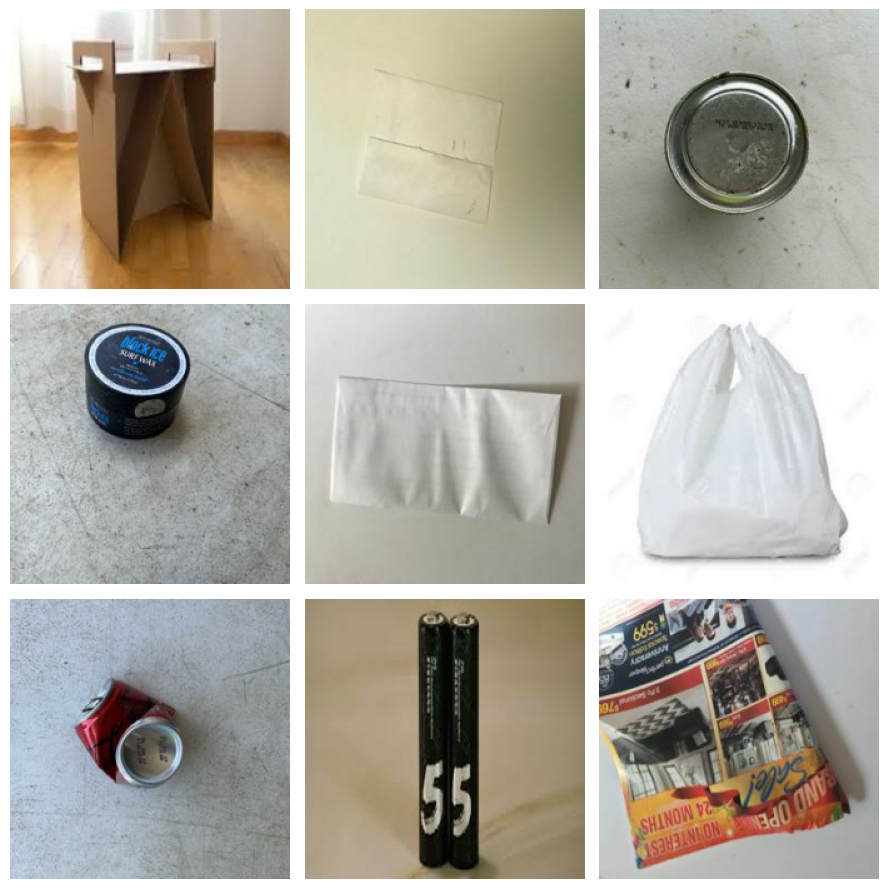

In [10]:
index = 13
example = train_orig.unbatch().take(1).as_numpy_iterator().next()

exaples = train_orig.unbatch().take(9).as_numpy_iterator()

plt.figure(figsize=(9, 9))

for i, (image, label) in enumerate(exaples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
def data_augmentor():

    data_aug = keras.models.Sequential()
    data_aug.add(layers.RandomFlip("horizontal_and_vertical"))
    data_aug.add(layers.RandomRotation(0.2))

    return data_aug

In [19]:
def model(augmentation_layer=data_augmentor()):
    IMG_SHAPE = IMG_SIZE + (3,)

    preprocess_input = keras.applications.mobilenet_v2.preprocess_input

    base_model = keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=IMG_SHAPE)

    x = augmentation_layer(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(DROP_OUT)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs, outputs)   

    return model


In [13]:
train_model = model()

model = model()  # Create your model
print(model.summary())

# Check the last layer specifically:
print(f"Output layer units: {model.layers[-1].units}")
print(f"NUM_CLASSES setting: {NUM_CLASSES}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Output layer units: 6
NUM_CLASSES setting: 6


In [14]:
if os.path.exists('./models/best_garbage.weights.h5'):
    train_model.load_weights('./models/best_garbage.weights.h5')

train_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./models/best_garbage.weights.h5',
    monitor='val_accuracy',  # or 'val_loss'
    save_best_only=True,
    save_weights_only=True,  # saves entire model
    mode='max',  # 'max' for accuracy, 'min' for loss
    verbose=1
)


with tf.device('/GPU:0'):
    history = train_model.fit(
        train,
        epochs=EPOCHS,
        validation_data=val,
        callbacks=[checkpoint_callback]
    )

Epoch 1/10


2025-09-09 01:15:52.017516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7679 - loss: 0.6709
Epoch 1: val_accuracy improved from None to 0.85174, saving model to ./models/best_garbage.weights.h5
348/348 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.7639 - loss: 0.6870 - val_accuracy: 0.8517 - val_loss: 0.4429
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7752 - loss: 0.6460
Epoch 2: val_accuracy did not improve from 0.85174
348/348 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.7678 - loss: 0.6813 - val_accuracy: 0.8481 - val_loss: 0.4415
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7637 - loss: 0.7022
Epoch 3: val_accuracy did not improve from 0.85174
348/348 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.7636 - loss: 0.6900 - val_accuracy: 0.8496 - val_loss: 0.4369
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7691 - loss: 0.6893
Epoch 4: val_accuracy did not improve from 0.85174
348/348 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accura

In [15]:

tune_model = train_model.layers[2] 
tune_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the `fine_tune_at` layer
for layer in tune_model.layers[:fine_tune_at]:
    layer.trainable = False

tune_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

with tf.device('/GPU:0'):
    fine_tune_history = train_model.fit(
        train,
        epochs=EPOCHS,
        validation_data=val,
        callbacks=[checkpoint_callback]
    )



Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7701 - loss: 0.6617
Epoch 1: val_accuracy did not improve from 0.85828
348/348 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.7692 - loss: 0.6693 - val_accuracy: 0.8496 - val_loss: 0.4371
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7749 - loss: 0.6492
Epoch 2: val_accuracy did not improve from 0.85828
348/348 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.7687 - loss: 0.6670 - val_accuracy: 0.8423 - val_loss: 0.4460
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7587 - loss: 0.6806
Epoch 3: val_accuracy did not improve from 0.85828
348/348 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.7637 - loss: 0.6751 - val_accuracy: 0.8401 - val_loss: 0.4660
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7644 - loss: 0.6876
Epoch 4: val_accuracy did not improve from 0.85828
348/348 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.7684 - loss: 0.6759 - val_accuracy

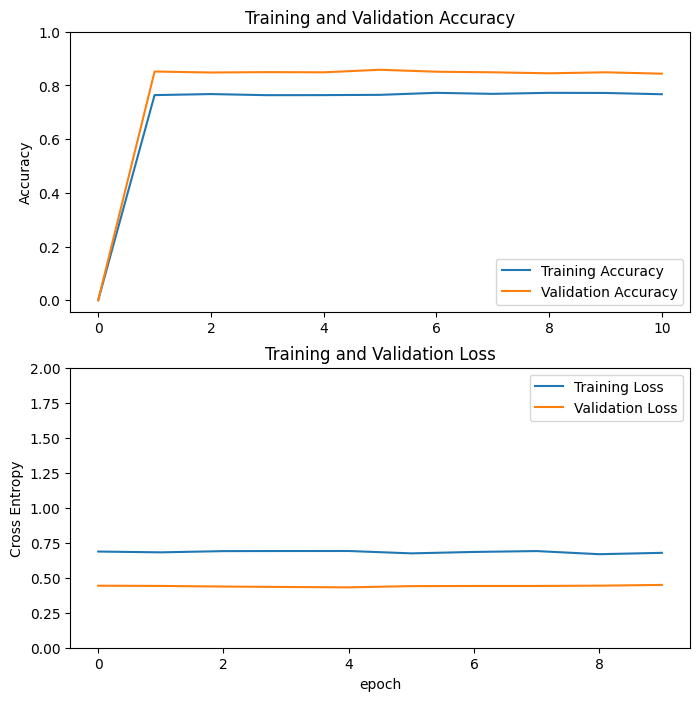

In [16]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = train_model.evaluate(test)
print(f'Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}')
# -*- coding: utf-8 -*-

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8531 - loss: 0.4233
Test accuracy: 0.8531, Test loss: 0.4233
